![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2F05+-+TensorFlow&file=05Tools+-+Monitoring.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/05%20-%20TensorFlow/05Tools%20-%20Monitoring.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2F05%2520-%2520TensorFlow%2F05Tools%2520-%2520Monitoring.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/05%20-%20TensorFlow/05Tools%20-%20Monitoring.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/05%20-%20TensorFlow/05Tools%20-%20Monitoring.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# 05Tools: Model Monitoring

Model training results in a model that reflects a translation of features to predictions.  Without further training or re-training, this becomes dependent on the training data.  Monitoring is essential for understanding risk, or trust, in a model to do the task it was created for.  There are multiple aspects that may be desired for monitoring:

- Features
    - At Prediction time
        - features shift from train time: training-serving **skew**
        - features change over time: prediction **drift**
        - feature attributions
            - From model explainability
        - Predictions themselves
        - considerations:
            - online predictions
            - batch predictions
            - edge preditions
    - At data time
        - values over time - feature store
        - features meaning changes over time
        - a change in feature stability over time may impact currently deployed models
        - changes in features may change their consideration for future model development

This notebook will setup model monitoring for a Vertex AI Endpoint hosted model.  Model Monitoring will be setup for skew and drift with thresholds set for all features and local feature attributions (explanations):
- numerical features difference is calculated with [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)
- categorical features difference is calculated with [L-infinity distance](https://en.wikipedia.org/wiki/Chebyshev_distance)

**Prerequisites:**
-  At least 1 of the notebooks in this series [05, 05a-05i]
   
**Resources:**
- [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
- [Model Monitoring Documentation](https://cloud.google.com/vertex-ai/docs/model-monitoring/overview)
- [Blog: Monitor Models with Vertex AI](https://cloud.google.com/blog/topics/developers-practitioners/monitor-models-training-serving-skew-vertex-ai)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/05tools_monitor_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/05tools_monitor_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'monitoring'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import aiplatform

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import time
import numpy as np
import matplotlib.pyplot as plt

clients:

In [4]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID)

parameters:

In [5]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"

---
## Get Vertex AI Endpoint

This project already has a model serving online predictions at a Vertex AI Endpoint.  This section will use the endpoint to retrieve the deployed model and get its information to use for batch prediction methods in this notebook.

### Get Endpoint

[Endpoint Properties and Methods](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint):

```python
endpoint
endpoint.display_name
endpoint.resource_name
endpoint.traffic_split
endpoint.list_models()
```

In [6]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    print(f"There does not appear to be an endpoint for SERIES = {SERIES}")

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/8352053052307406848


In [7]:
endpoint.display_name

'05'

In [8]:
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/8352053052307406848?project=statmike-mlops-349915


---
## Get The Deployed Model

In [9]:
model = aiplatform.Model(
    model_name = endpoint.list_models()[0].model+f'@{endpoint.list_models()[0].model_version_id}'
)

In [10]:
model.display_name

'05_05a'

In [11]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_05_05a@6'

In [12]:
model.uri

'gs://statmike-mlops-349915/05/05a/models/20230210132930/model'

In [13]:
model.version_id

'6'

In [14]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/properties?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_05a/versions/6/properties?project=statmike-mlops-349915


### Review Model Information

In [15]:
model.display_name

'05_05a'

In [16]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/model_05_05a'

In [17]:
model.version_id

'6'

In [18]:
model.version_description

'run-20230210132930'

In [19]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_05_05a@6'

In [20]:
model.supported_input_storage_formats

['jsonl', 'bigquery', 'csv', 'tf-record', 'tf-record-gzip', 'file-list']

In [21]:
model.name

'model_05_05a'

In [22]:
model.uri

'gs://statmike-mlops-349915/05/05a/models/20230210132930/model'

In [23]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/properties?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_05_05a/versions/6/properties?project=statmike-mlops-349915


---
### Retrieve Records For Prediction

In [24]:
n = 1000
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

In [25]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.240428,0.037603,0.380026,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.265080,-0.060003,-0.053585,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,-0.374356,0.196006,0.656552,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-0.923275,-0.545992,-0.252324,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0


Remove columns not included as features in the model:

In [26]:
newobs = pred.to_dict(orient='records')
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

In [27]:
len(newobs)

1000

---
### Predictions

For more ways to request predictions from a Vertex AI Endpoint see the [05Tools - Prediction - Online.ipynb](./05Tools%20-%20Prediction%20-%20Online.ipynb) notebook.

#### Get Prediction: Python Client

In [28]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

Prediction(predictions=[[0.999802768, 0.000197230533]], deployed_model_id='5147434054177521664', model_version_id='6', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05a', explanations=None)

In [29]:
prediction.predictions[0]

[0.999802768, 0.000197230533]

In [30]:
np.argmax(prediction.predictions[0])

0

### Explanations

If the endpoint is hosting a model with traffic that is also enable for feature-based explanations using the `explanationSpec` then also enable monitoring of feature attributions.  To see how to enable a custom model for feature-based explanations, and to enable them for the model on this endpoint, review the [05Tools - Explainability - Feature-Based](./05Tools%20-%20Explainability%20-%20Feature-Based.ipynb) notebook.

In [31]:
endpoint.traffic_split

{'5147434054177521664': 100}

In [32]:
explanation_models = [m for m in endpoint.list_models() if endpoint.traffic_split[m.id] > 0.0 and m.explanation_spec]

prediction =  [0.999802768, 0.000197230533]
attributions ...
baseline output: 0.9997043013572693
instance output: 0.9998027682304382
output_index: [0]
output_name: logistic
approximation error: 0.0005706747590846932


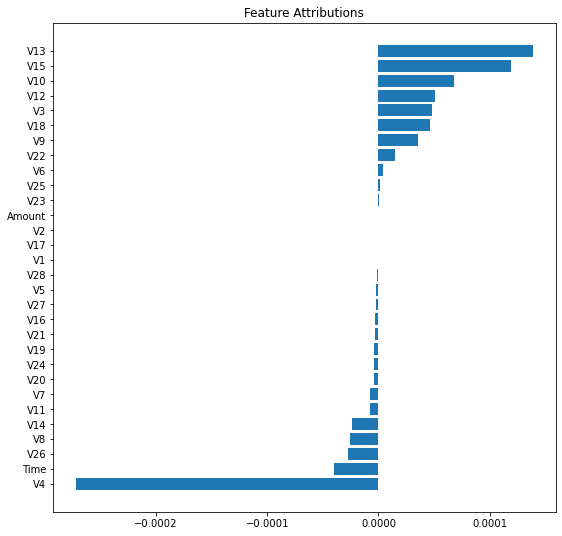

In [33]:
if explanation_models:
    explanation = endpoint.explain(instances = newobs[0:1])
    print('prediction = ', explanation.predictions[0])
    print("attributions ...")
    print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
    print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
    print("output_index:",explanation.explanations[0].attributions[0].output_index)
    print("output_name:",explanation.explanations[0].attributions[0].output_name)
    print("approximation error:",explanation.explanations[0].attributions[0].approximation_error)
    
    features = []
    scores = []
    for k in explanation.explanations[0].attributions[0].feature_attributions:
        features.append(k)
        scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
    features = [x for _, x in sorted(zip(scores, features))]
    scores = sorted(scores)
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 9)
    ax.barh(features, scores)
    plt.title('Feature Attributions')
    fig.show()

---
## Monitoring

### Training Data

In [39]:
query = f"""
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_trainingView` AS
    SELECT * EXCEPT(splits, {VAR_OMIT.replace(' ',',')})
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN'
"""
createView = bq.query(query)
createView.result()

### Sampling Strategy

In [40]:
sampling_config = aiplatform.model_monitoring.RandomSampleConfig(
    sample_rate = 1.0
)

### Schedule

In [41]:
schedule_config = aiplatform.model_monitoring.ScheduleConfig(
    monitor_interval = 1 #  min is one hour = 1
)

### Alerts

In [42]:
alerting_config = aiplatform.model_monitoring.EmailAlertConfig(
    user_emails = ['statmike@google.com'],
    enable_logging = True
)

### Objective

In [43]:
objective_config = aiplatform.model_monitoring.ObjectiveConfig()

### Thresholds
Set all features to a very low threshold for this example - more sensitive to alerts: 0.001

In [44]:
query = f"""
SELECT column_name, data_type
FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = '{BQ_TABLE}_trainingView' and column_name != '{VAR_TARGET}'
"""
schema = bq.query(query).to_dataframe()
thresholds = dict(zip(schema['column_name'].tolist(), [0.001] * schema.shape[0]))
thresholds

{'Time': 0.001,
 'V1': 0.001,
 'V2': 0.001,
 'V3': 0.001,
 'V4': 0.001,
 'V5': 0.001,
 'V6': 0.001,
 'V7': 0.001,
 'V8': 0.001,
 'V9': 0.001,
 'V10': 0.001,
 'V11': 0.001,
 'V12': 0.001,
 'V13': 0.001,
 'V14': 0.001,
 'V15': 0.001,
 'V16': 0.001,
 'V17': 0.001,
 'V18': 0.001,
 'V19': 0.001,
 'V20': 0.001,
 'V21': 0.001,
 'V22': 0.001,
 'V23': 0.001,
 'V24': 0.001,
 'V25': 0.001,
 'V26': 0.001,
 'V27': 0.001,
 'V28': 0.001,
 'Amount': 0.001}

### Skew

In [45]:
skew_config = aiplatform.model_monitoring.SkewDetectionConfig(
    data_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_trainingView',
    skew_thresholds = thresholds,
    attribute_skew_thresholds = thresholds,
    target_field = VAR_TARGET
)
objective_config.skew_detection_config = skew_config

### Drift

In [46]:
drift_config = aiplatform.model_monitoring.DriftDetectionConfig(
    drift_thresholds = thresholds,
    attribute_drift_thresholds = thresholds
)
objective_config.drift_detection_config = drift_config

### Explanations (Feature Attributions)

If the endpoint is hosting a model with traffic that is also enable for feature-based explanations using the `explanationSpec` then also enable monitoring of feature attributions.  To see how to enable a custom model for feature-based explanations, and to enable them for the model on this endpoint, review the [05Tools - Explainability - Feature-Based](./05Tools%20-%20Explainability%20-%20Feature-Based.ipynb) notebook.

In [48]:
if explanation_models:
    explanation_config = aiplatform.model_monitoring.ExplanationConfig()
    objective_config.explanation_config = explanation_config

### Job

[aiplatform.ModelDeploymentMonitoringJob.create()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.ModelDeploymentMonitoringJob#google_cloud_aiplatform_ModelDeploymentMonitoringJob_create)

In [51]:
job = aiplatform.ModelDeploymentMonitoringJob.create(
    display_name = f'{SERIES}_{EXPERIMENT}',
    logging_sampling_strategy = sampling_config,
    schedule_config = schedule_config,
    alert_config = alerting_config,
    objective_configs = objective_config,
    project = PROJECT_ID,
    location = REGION,
    endpoint = endpoint,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
)

Creating ModelDeploymentMonitoringJob
ModelDeploymentMonitoringJob created. Resource name: projects/1026793852137/locations/us-central1/modelDeploymentMonitoringJobs/510248849273520128
To use this ModelDeploymentMonitoringJob in another session:
mdm_job = aiplatform.ModelDeploymentMonitoringJob('projects/1026793852137/locations/us-central1/modelDeploymentMonitoringJobs/510248849273520128')
View Model Deployment Monitoring Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/model-deployment-monitoring/510248849273520128?project=1026793852137


In [54]:
job.state

<JobState.JOB_STATE_PENDING: 2>

### Confirmation Email
Confirmation email is sent letting you know the model monitoring service has been enabled for the endpoint:

<p align="center">
  <img alt="Confirmation Email" src="../architectures/notebooks/05/monitoring/1-request.png" width="75%">
</p>

### Input Schema Generation
After 1000 predict request, the monitoring service will automatically create the `input_schema`:

In [192]:
#instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

In [165]:
#predictions = endpoint.predict(instances = newobs)

In [55]:
explanations = endpoint.explain(instances = newobs)

In [64]:
explanations.predictions[0]

[0.999802768, 0.000197230911]

wait for 1 hour...

### BigQuery Logging Table

In [65]:
query = f"""
SELECT *
FROM `{BQ_PROJECT}.model_deployment_monitoring_{endpoint.name}.serving_predict`
LIMIT 5
"""
bq.query(query).to_dataframe()

,endpoint,deployed_model_id,logging_time,request_id,request_payload,response_payload


### Run Predictions

In [68]:
n = 2000
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

In [70]:
test_obs = pred.to_dict(orient='records')

In [71]:
#instances = [json_format.ParseDict(test_ob, Value()) for test_ob in test_obs]

In [77]:
explanations = endpoint.explain(instances = test_obs[0:1000])

In [78]:
for obs in test_obs[1000:]:
    explanation = endpoint.explain(instances = [obs])
#explanations = endpoint.explain(instances = test_obs[1000:])

In [76]:
predictions = endpoint.predict(instances = test_obs[0:1000])
predictions = endpoint.predict(instances = test_obs[1000:])

wait for 1 hour...

### Alert Email
An email with alerts will be triggered after one of the first hours jobs picks up the predictions above.  The threshold was set so sensitive on all features that this is expected and likely includes every feature.  The type of alert is training-serving **skew**, indicating a detect different between the predictions and the training data.

<p align="center">
  <img alt="Confirmation Email" src="../architectures/notebooks/05/monitoring/2-alert.png" width="75%">
</p>

### Alerts In Console
In addition to the email with alerts, the console also logs alerts and provides a more interactive view into the data.  From the Vertex AI Endpoints menu, select the endpoint, select monitoring, select alerts, and then click any feature for distribution graphs of training data and recent predictions.


<p align="center">
  <img alt="Confirmation Email" src="../architectures/notebooks/05/monitoring/3-alert_console.png" width="75%">
</p>

In [230]:
print(f"Use this link to quickly get to the monitoring alerts in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}/models/{list(endpoint.traffic_split.keys())[0]}/alerts?monitoring={job.name}&project={PROJECT_ID}")

Use this link to quickly get to the monitoring alerts in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/1961322035766362112/models/6805735083375329280/alerts?monitoring=257115021719371776&project=statmike-mlops-349915


### Run Predictions Each Hour with Progressive Drift

In [267]:
n = 1000

query =  f"""
SELECT *
FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
WHERE splits='TEST'
LIMIT {n}
"""

pred = bq.query(query = query).to_dataframe()

In [268]:
runHours = 8

runs = 0
while runs <= runHours:
    # increment runs
    runs += 1
    
    # force drift for features V1 through V10
    # each iteration add positive noise = abs(random(mean = 0, sd = .1*sd)) 
    for v in range(1, 11, 1):
        pred[f'V{v}'] = pred[f'V{v}'] + np.abs(np.random.normal(0, pred[f'V{v}'].std()/10, size=pred.shape[0]))
    
    # prepare instances
    test_obs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')
    instances = [json_format.ParseDict(test_ob, Value()) for test_ob in test_obs]
    
    # request predictions
    predictions = endpoint.predict(instances = instances)
    
    # wait an hour: 60 seconds * 60 minutes
    time.sleep(3600)
    

### Alert Email(s)

Before the 8 hours of progressive drift runs finished an alert email was sent indicating both **skew** detection as before and **drift** detection alerts.  This is also in part due to the very low threshold and more features than those with induced drift are part of alerts.
    
<p align="center">
  <img alt="Alert Email" src="../architectures/notebooks/05/monitoring/4a-drift.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Alert Email" src="../architectures/notebooks/05/monitoring/4b-drift.png" width="45%">
</p>    

After several hours the **drift** alerts are focused in on just the features the method above forced drift on: `V1` through `V10`:

<p align="center">
  <img alt="Alert Email" src="../architectures/notebooks/05/monitoring/5-drift.png" width="85%">
</p>   

### Console Review of Drift

Reviewing the **drift** alerts in the cosole gives a distribution chart for each monitoring time which can be click through to view the pattern over time:

<p align="center">
  <img alt="Drift in Console" src="../architectures/notebooks/05/monitoring/6-drift_console.png" width="85%">
</p>   

### Removing Monitoring From Endpoint

In [177]:
#job.pause()
#job.delete()

resource name: projects/1026793852137/locations/us-central1/modelDeploymentMonitoringJobs/2063551053504184320

In [204]:
jobs = job.list(filter=f"display_name={SERIES}_{EXPERIMENT}")

In [205]:
jobs[0].state

<JobState.JOB_STATE_RUNNING: 3>